In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [3]:
print(pd.__version__)

0.23.4


In [4]:
%matplotlib widget

## Property Data

In [5]:
id_halo='418336'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

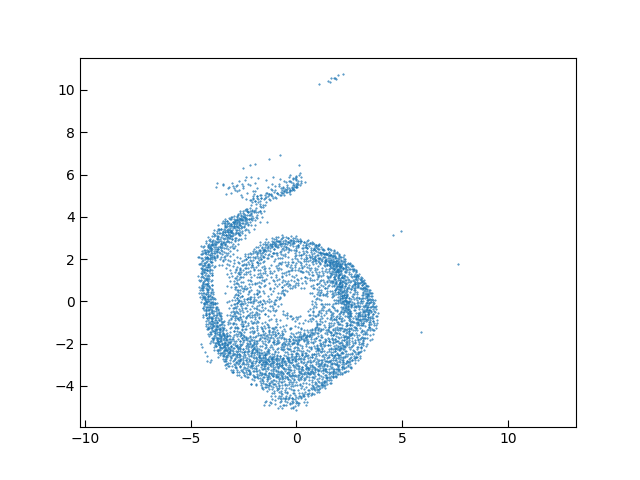

In [6]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [7]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [8]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


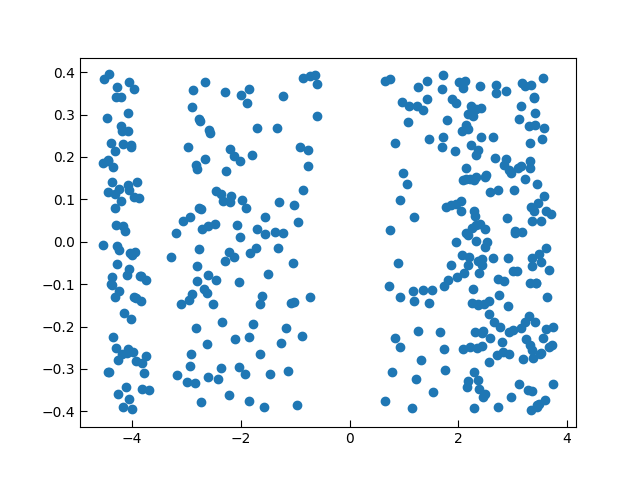

In [9]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


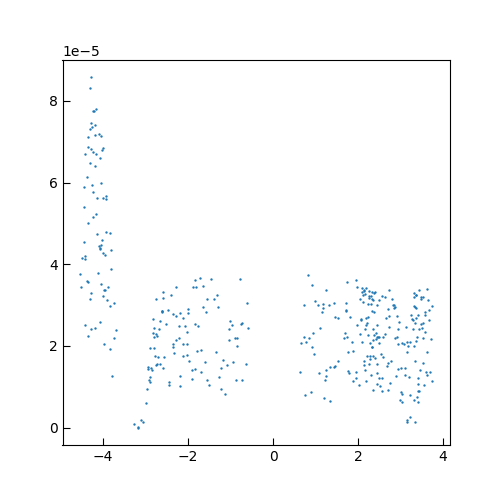

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [11]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

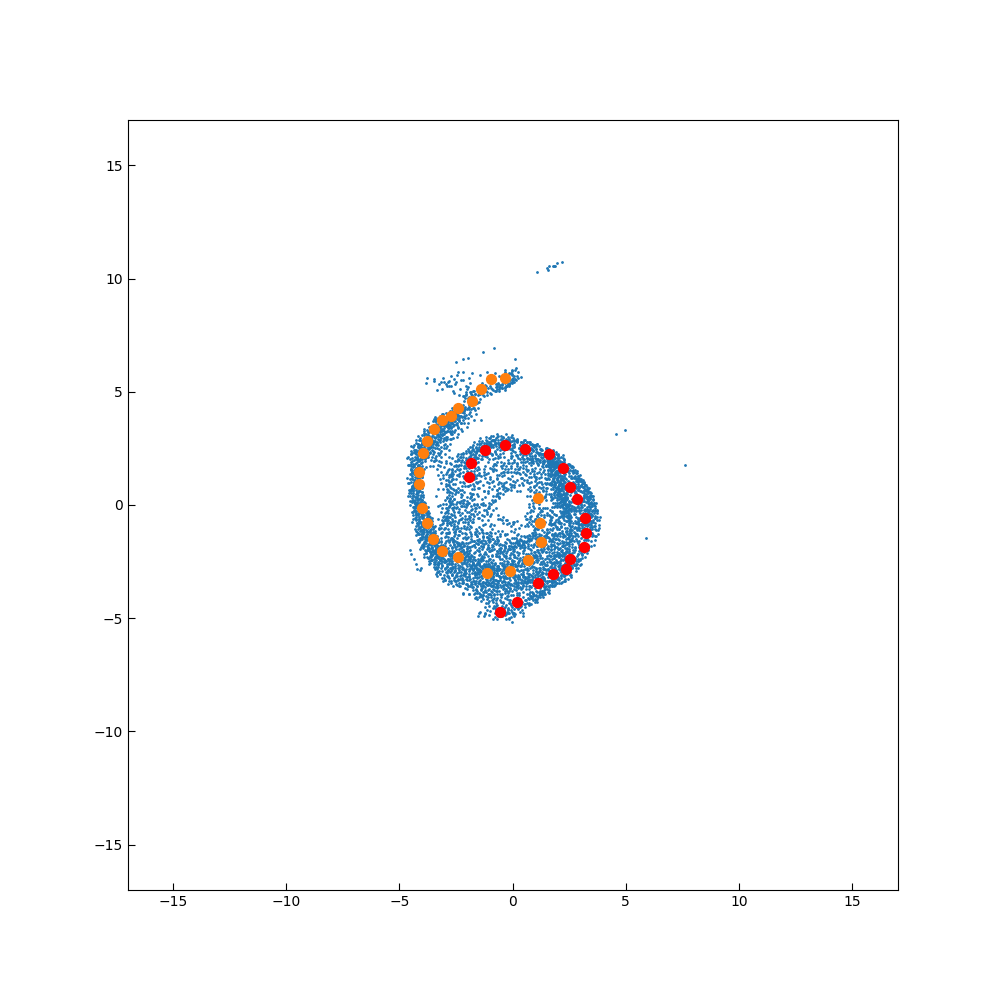

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 17
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [12]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [13]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [14]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [15]:
b = 0.3

In [16]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

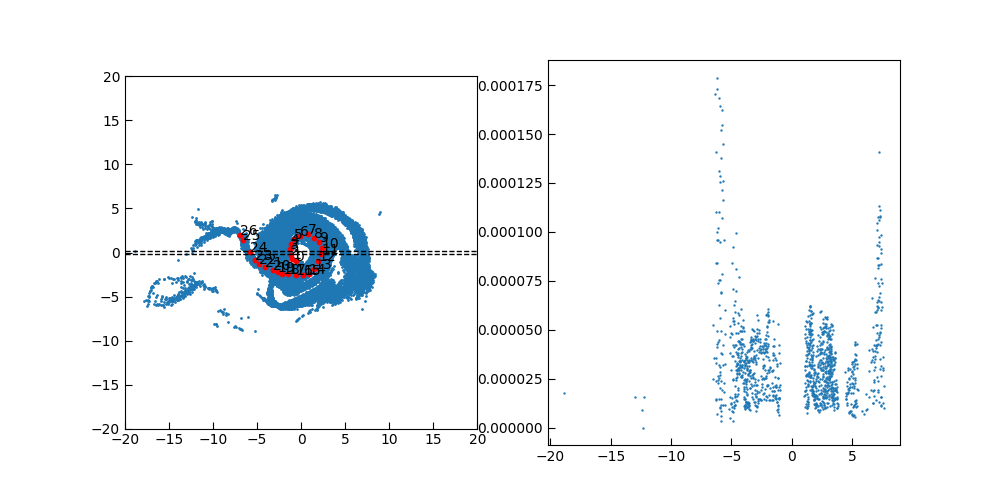

In [17]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

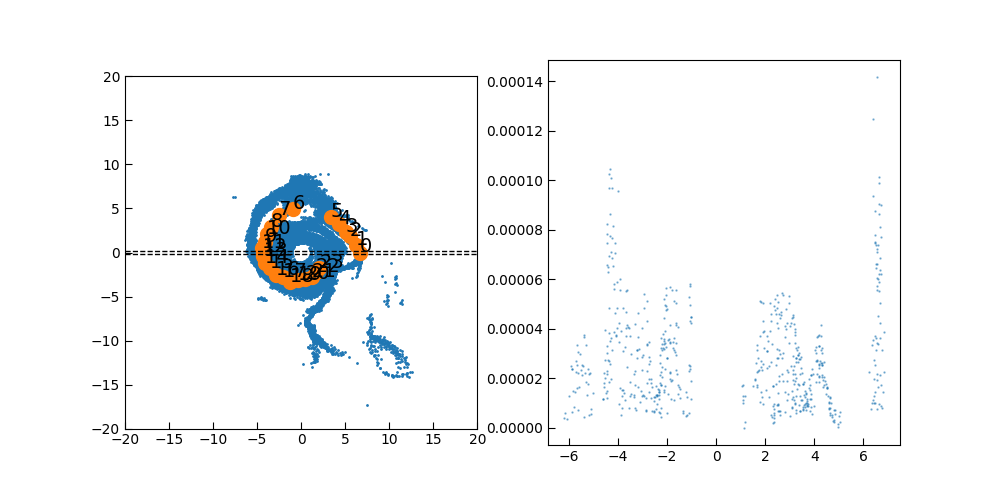

In [18]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 0
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [20]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [21]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [22]:
arm = df_arm2.copy(deep=True)

In [23]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-2.663961,-6.103490,2,0,"({'x_rot': [-1.0630744087992277, -1.0270675120...","{'x_rot': [-1.0630744087992277, -1.02706751204...",4.300847,"{'x_rot': [6.659525641353639, 6.23418520119376...","{'x_rot': 6.659525641353639, 'y_rot': 3.996802...","{'x_band': [-1.0630744087992277, -1.0270675120..."
1,-1.689935,-6.064529,2,1,"({'x_rot': [-1.0691238061663233, -1.0494509742...","{'x_rot': [-1.0691238061663233, -1.04945097423...",4.440624,"{'x_rot': [6.594575998590235, 6.29558537336934...","{'x_rot': 6.295585373369349, 'y_rot': 8.881784...","{'x_band': [-1.0691238061663233, -1.0494509742..."
2,-0.521104,-5.830763,2,2,"({'x_rot': [-1.0456370950476608, -1.0478341734...","{'x_rot': [-1.0456370950476608, -1.04783417348...",4.623254,"{'x_rot': [6.316397204988673, 6.19088627412722...","{'x_rot': 5.854002586372444, 'y_rot': 2.664535...","{'x_band': [-1.0456370950476608, -1.0478341734..."
3,0.102273,-5.596997,2,3,"({'x_rot': [-1.0154845143368985, -1.0305560697...","{'x_rot': [-1.0154845143368985, -1.03055606974...",4.730660,"{'x_rot': [6.053801686274534, 6.03264234828058...","{'x_rot': 5.597931079121865, 'y_rot': 5.412337...","{'x_band': [-1.030556069747264, -1.06440827245..."
4,1.310065,-5.207386,2,4,"({'x_rot': [-0.9131817662879751, -0.9548477967...","{'x_rot': [-0.9131817662879751, -0.95484779671...",4.958852,"{'x_rot': [5.269108627964689, 5.46896375051738...","{'x_rot': 5.36965016311795, 'y_rot': 4.2188474...","{'x_band': [-1.0251817200655975, -1.1090846491..."
5,2.323052,-4.661932,2,5,"({'x_rot': [-0.7727387929949887, -0.8375918739...","{'x_rot': [-0.7727387929949887, -0.83759187397...",5.174678,"{'x_rot': [4.2747115954240655, 4.6742534562985...","{'x_rot': 5.20866380473188, 'y_rot': 2.2204460...","{'x_band': [-1.100508756852044, -1.18661541965..."
6,4.933442,-1.155438,2,6,"({'x_rot': [0.07596962942411273, -0.0433641296...","{'x_rot': [0.07596962942411273, -0.04336412964...",6.053127,"{'x_rot': [-1.2019659481116036, -0.26248710578...","{'x_rot': 5.066940230817353, 'y_rot': 1.110223...","{'x_band': [1.2232759421410533, 1.291854285680..."
7,4.894481,0.636769,2,7,"({'x_rot': [0.4463830958713919, 0.329500955684...","{'x_rot': [0.4463830958713919, 0.3295009556847...",0.129373,"{'x_rot': [-3.429123389612963, -2.458210900345...","{'x_rot': 4.935728408947894, 'y_rot': 1.110223...","{'x_band': [1.225327818259103, 1.3113137223550..."
8,4.076299,1.961445,2,8,"({'x_rot': [0.7287786264366799, 0.626645546351...","{'x_rot': [0.7287786264366799, 0.6266455463510...",0.448481,"{'x_rot': [-5.0469692683200496, -4.15237440229...","{'x_rot': 4.523657461173995, 'y_rot': 0.0}","{'x_band': [1.0754750432998668, 1.099246787294..."
9,2.790584,3.286120,2,9,"({'x_rot': [0.9839474040587927, 0.916392013480...","{'x_rot': [0.9839474040587927, 0.9163920134808...",0.866765,"{'x_rot': [-6.37668840923448, -5.7165078260707...","{'x_rot': 4.311142179102924, 'y_rot': 0.0}","{'x_band': [1.0495916363166518, 1.072868333615..."


(-2.5, 2.5)

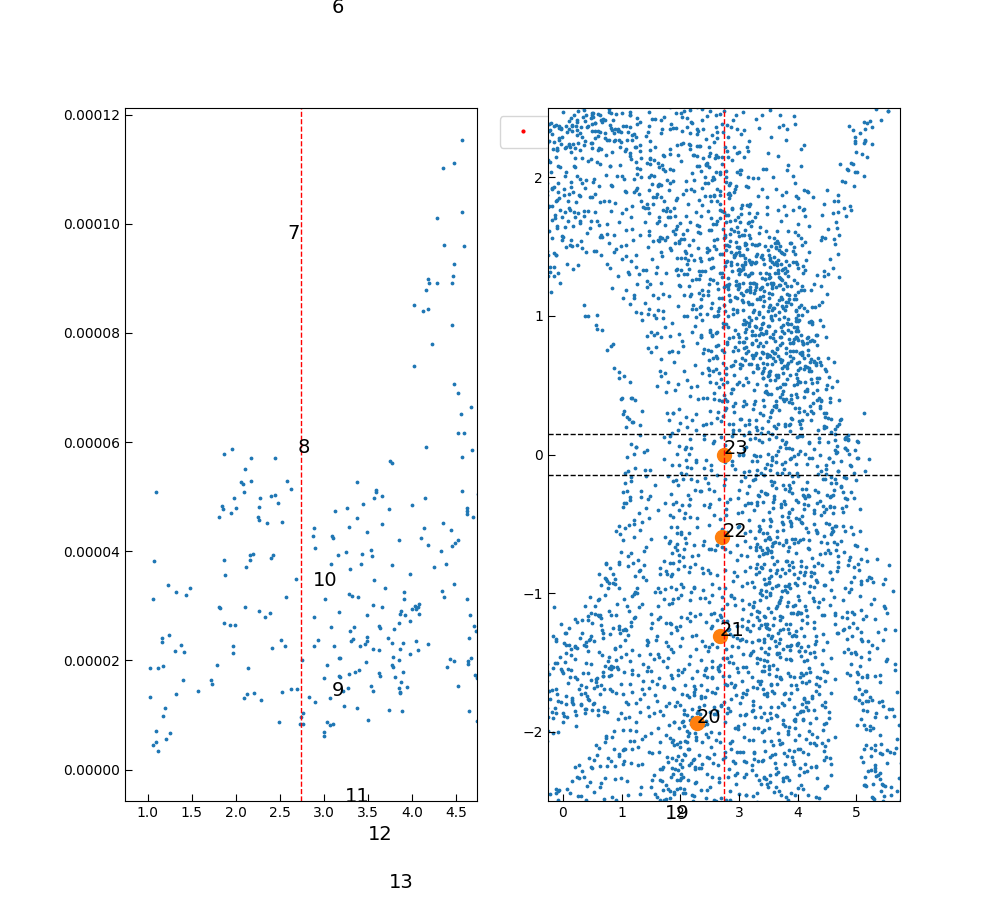

In [282]:
%matplotlib widget

n= 23 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

## %run Routines_and_data/gauss_asym.py

In [283]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [284]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [285]:
n

23

(0.0, 4.524166596706281e-05)

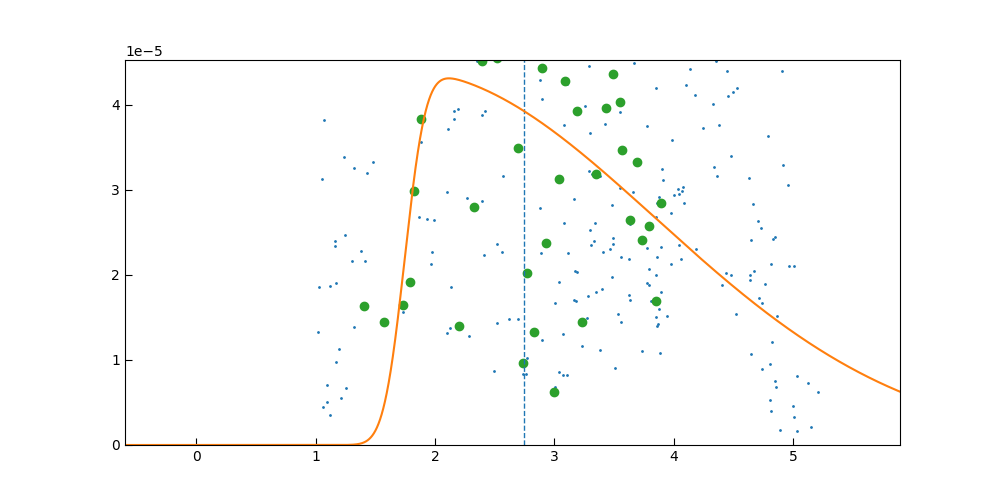

In [286]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [287]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [288]:
df_params.tail()

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
18,0.000059,3.687480,0.05,False,-1.871400,19.0,0.770503,0.000004,0.098246,1.070307,0.136054,"[2.1154386777847085, 2.2007803757208046, 2.295...",-2.702922,"[7.655096056339095e-06, 1.1962344215609434e-05...",1.610795
19,0.000103,1.737883,0.05,False,6.275440,20.0,1.693766,0.000005,0.037777,1.768234,0.133407,"[1.5809876627129558, 1.6180722892599722, 1.673...",-2.897727,"[1.7032955433705512e-05, 1.898256071307957e-05...",0.753653
20,0.000090,2.361466,0.05,False,2.871810,21.0,1.247320,0.000006,0.066432,1.545613,0.192977,"[2.3214344793493815, 2.394840163266845, 2.4324...",-2.975649,"[2.45931518161307e-05, 3.1604464245704085e-05,...",0.013393
21,0.000117,3.787407,0.05,False,-4.332251,22.0,1.630286,0.000016,0.072579,2.638716,0.394996,"[2.095628821575783, 2.180271124928596, 2.20985...",-2.702922,"[1.8979360229948636e-05, 3.923832675528347e-05...",-0.648945
22,0.000116,1.746039,0.05,False,15.101455,23.0,2.103272,0.000019,0.064238,11.814870,0.459589,"[1.4012691167238172, 1.572701410548221, 1.7274...",-2.469156,"[1.6330819118022482e-05, 1.4409432922591422e-0...",-1.194399


In [289]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [290]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [291]:
arm.iloc[n].id

23

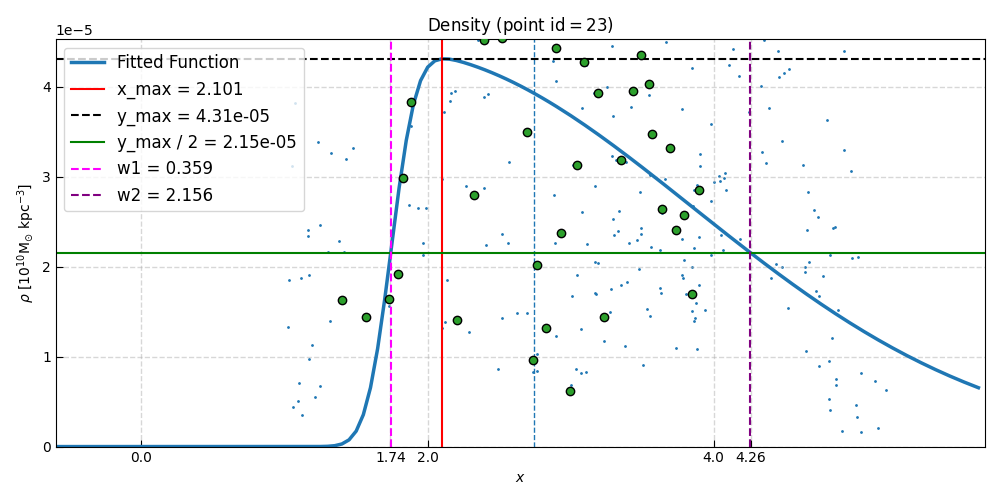

In [292]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

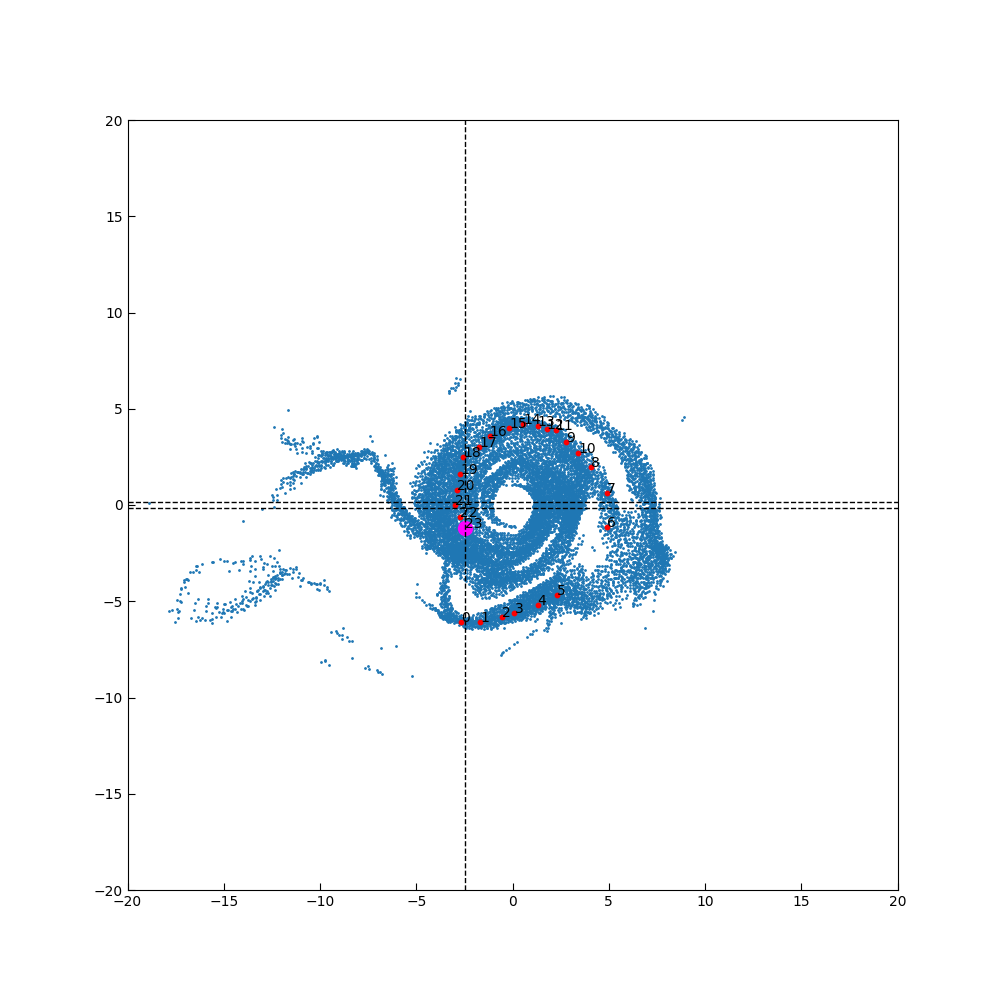

In [293]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [294]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [166]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

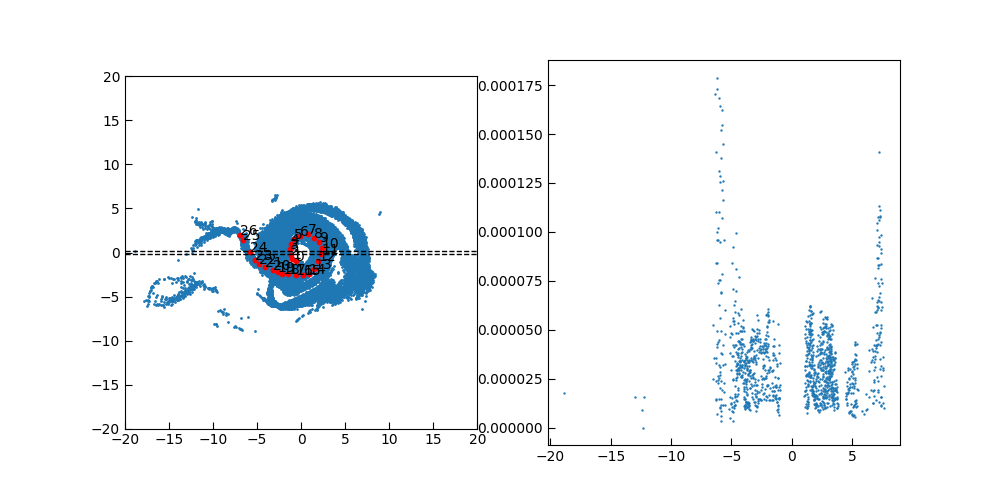

In [295]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [296]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [297]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-0.637987,-0.960633,1,0,"({'x_rot': [-1.0264100840503059, -0.9710112085...","{'x_rot': [-1.0264100840503059, -0.97101120856...",4.126143,"{'x_rot': [1.1531883688247397, 1.1524479399743...","{'x_rot': 1.1531883688247397, 'y_rot': -3.3306...","{'x_band': [-1.0550478209710918, -1.0594922514..."
1,-0.988636,-0.726867,1,1,"({'x_rot': [-0.8606645990455659, -0.7719856752...","{'x_rot': [-0.8606645990455659, -0.77198567525...",3.775568,"{'x_rot': [1.0830461460027068, 1.2270848891890...","{'x_rot': 1.2270848891890833, 'y_rot': 1.11022...","{'x_band': [-1.0555953022183862, -1.0938726327..."
2,-1.105519,-0.337256,1,2,"({'x_rot': [-0.6014980305644728, -0.4909172976...","{'x_rot': [-0.6014980305644728, -0.49091729764...",3.437691,"{'x_rot': [0.8905267281753044, 1.1577059085733...","{'x_rot': 1.1558180065305972, 'y_rot': 5.55111...","{'x_band': [-1.0733017001651606, -1.3152849322..."
3,-1.261364,0.403003,1,3,"({'x_rot': [0.008665467249015513, 0.1264615968...","{'x_rot': [0.008665467249015513, 0.12646159686...",2.832345,"{'x_rot': [0.3153617264151557, 0.7205221460888...","{'x_rot': 1.3241789305204021, 'y_rot': 5.55111...","{'x_band': [-1.2812229009845568, -1.3093650159..."
4,-1.183442,0.948458,1,4,"({'x_rot': [0.3912350061338615, 0.492578627270...","{'x_rot': [0.3912350061338615, 0.4925786272709...",2.465974,"{'x_rot': [-0.10292666736520517, 0.31688487969...","{'x_rot': 1.5166100704684333, 'y_rot': 0.0}","{'x_band': [-1.2456915426658244, 1.03972625374..."
5,-0.793831,1.493912,1,5,"({'x_rot': [0.7531424711271651, 0.820620159639...","{'x_rot': [0.7531424711271651, 0.8206201596393...",2.059230,"{'x_rot': [-0.5489345529014572, -0.17796308277...","{'x_rot': 1.6917275186115543, 'y_rot': 4.44089...","{'x_band': [1.0959691432693357, 1.191425953363..."
6,-0.170455,1.883523,1,6,"({'x_rot': [0.9886999379248492, 1.012311585063...","{'x_rot': [0.9886999379248492, 1.0123115850639...",1.661048,"{'x_rot': [-0.899222001760761, -0.634803360431...","{'x_rot': 1.89121987516497, 'y_rot': 3.3306690...","{'x_band': [1.0123115850639979, 1.050158159978..."
7,0.764610,2.156250,1,7,"({'x_rot': [1.0687459334676954, 1.040941394192...","{'x_rot': [1.0687459334676954, 1.0409413941924...",1.230028,"{'x_rot': [-1.1186175225539925, -1.01548438884...","{'x_rot': 2.2878031188019987, 'y_rot': 1.11022...","{'x_band': [1.0687459334676954, 1.040941394192..."
8,1.504870,1.610795,1,8,"({'x_rot': [0.9629804693728368, 0.890789812588...","{'x_rot': [0.9629804693728368, 0.8907898125881...",0.819383,"{'x_rot': [-1.1374943466709357, -1.20605424585...","{'x_rot': 2.204381115905242, 'y_rot': 2.220446...","{'x_band': [1.0432833593500217, 1.074059368496..."
9,2.050325,1.182224,1,9,"({'x_rot': [0.7850692317784058, 0.687946106133...","{'x_rot': [0.7850692317784058, 0.6879461061337...",0.523038,"{'x_rot': [-1.0325419113317909, -1.21954170996...","{'x_rot': 2.3667456394457482, 'y_rot': 2.22044...","{'x_band': [1.087369050129007, 1.0968024885113..."


(-2.5, 2.5)

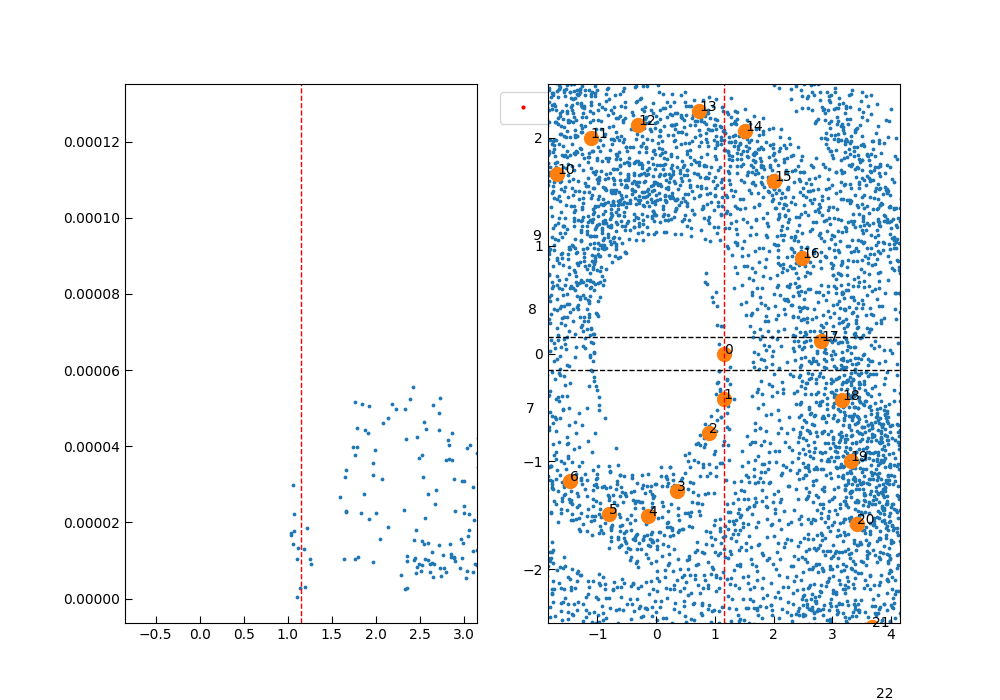

In [524]:
n= 0 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 10)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [525]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [526]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(0.0, 6.292184338802447e-05)

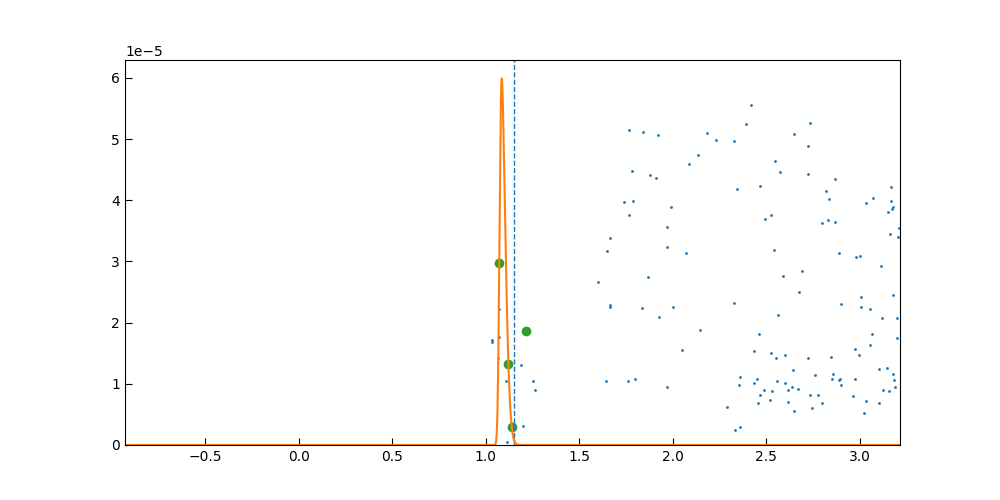

In [527]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [528]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [529]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000055,7.377166,0.05,False,-1.290120,26.0,0.423710,9.10437e-06,0.30048,2.80811,0.281314,"[6.454951293265377, 6.536199612202063, 6.58180...",-6.988636,"[3.087833486902426e-05, 1.668477266280261e-05,...",2.039367
1,0.000060,6.836021,0.05,False,1.462929,25.0,0.233388,7.26411e-06,0.0972328,1.91481,0.105857,"[6.180784250590531, 6.23930673582046, 6.318023...",-6.599026,"[9.528411380315098e-06, 6.432551666442195e-06,...",1.454951
2,0.000135,5.693620,0.05,False,7.147001,24.0,0.689756,3.78716e-05,0.053129,10.0764,0.295929,"[5.219015488877687, 5.662690674522453, 5.69241...",-5.819805,"[9.225006566119546e-06, 9.603993975876185e-05,...",0.091315
3,0.000135,5.676365,0.05,False,-4.901331,23.0,0.918322,1.22056e-05,0.0501181,2.30888,0.139266,"[4.306020391099527, 4.353129371662689, 4.40736...",-5.274351,"[3.979903038035868e-05, 5.1594363600230275e-05...",-0.882711
4,0.000147,5.295446,0.05,False,-3.033858,22.0,1.052890,1.02729e-05,0.0740611,1.32503,0.14823,"[3.4162938383407195, 3.4687025530005053, 3.524...",-4.728896,"[2.579763191120724e-05, 2.0682469658446668e-05...",-1.350244
5,0.000110,4.877141,0.05,False,-3.436645,21.0,0.898697,8.14566e-06,0.0579538,1.69652,0.122474,"[3.2388853249820864, 3.3037075877409117, 3.343...",-4.144481,"[1.4668622241363032e-05, 2.6513358984021412e-0...",-1.661932
6,0.000104,4.624817,0.05,False,-9.446928,20.0,1.022669,5.67884e-06,0.0258935,3.52126,0.0763168,"[2.644559109112736, 2.703300496560731, 2.74964...",-3.209416,"[1.419218811449281e-05, 1.4191059934398868e-05...",-1.973620
7,0.000106,4.573253,0.05,False,-3.872740,19.0,1.095169,6.55893e-06,0.0535509,1.48798,0.116784,"[2.331955808411167, 2.521366111284917, 2.58097...",-2.663961,"[4.463487337267222e-06, 9.640069463877307e-06,...",-2.207386
8,0.000087,4.347162,0.05,False,-3.505723,18.0,1.152216,4.52044e-06,0.0512684,1.02561,0.111413,"[2.130879640721417, 2.2919118954526967, 2.3771...",-2.118506,"[7.132956904308896e-06, 4.473436090697071e-06,...",-2.402192
9,0.000106,3.344710,0.05,False,-2.054876,17.0,1.309150,9.72868e-06,0.186169,1.39177,0.362331,"[1.5493117818562752, 1.6371375276360216, 1.672...",-1.456169,"[2.0802645569755146e-05, 2.7394402683175598e-0...",-2.402192


In [530]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 2.32386e-06
center                                                        1.07352
delta                                                            0.05
fractured                                                       False
gamma                                                         3.20953
id_tracing                                                          0
sigma                                                       0.0258794
stderr_amplitude                                              0.88737
stderr_center                                                 7637.49
stderr_gamma                                              2.00041e+07
stderr_sigma                                                  1748.11
x                   [1.0718274972857524, 1.121095301422239, 1.1391...
x_tracing                                                   -0.637987
y                   [2.9799189105740755e-05, 1.3224827924292052e-0...
y_tracing           

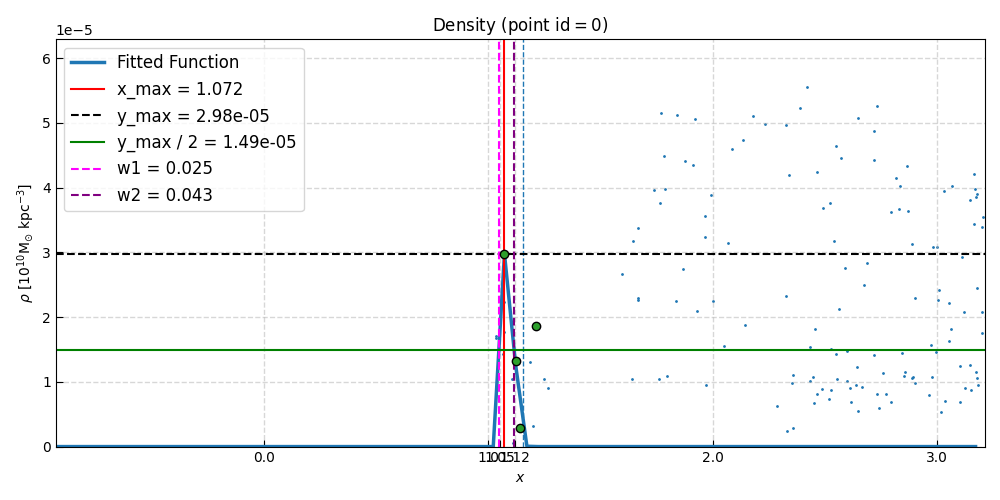

In [531]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

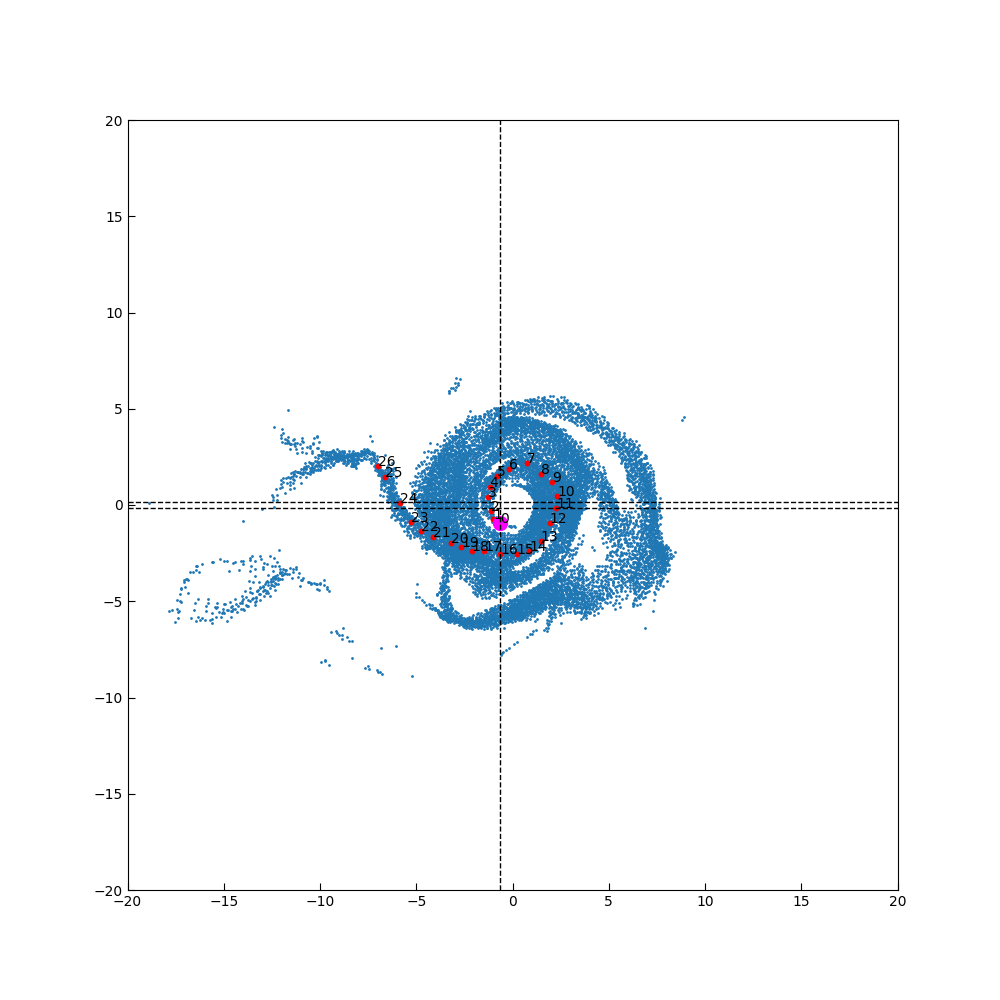

In [532]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [533]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')